In [26]:
#libraries
import numpy as np
import pandas as pd
#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve
#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#for handling imbalance
from imblearn.over_sampling import SMOTE

#load dataset
df=pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()
df.info()

#data cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#Drop missing values
df.dropna(inplace=True)

#drop customerid
df.drop('customerID', axis=1, inplace=True)

df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

df = pd.get_dummies(df, drop_first=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

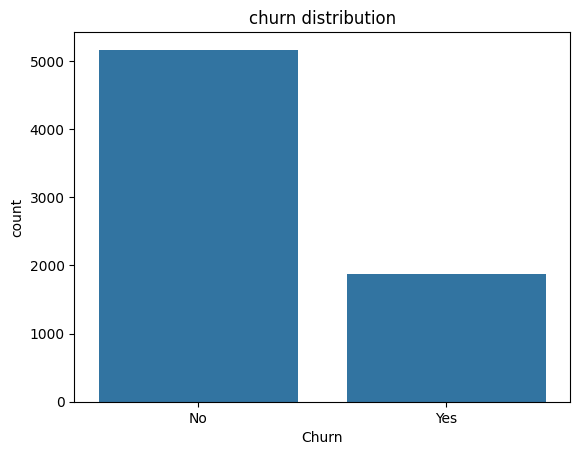

In [10]:
#EDA
#churn distribution
import seaborn as sns # Added import statement
sns.countplot(x='Churn',data=df)
plt.title("churn distribution")
plt.show()

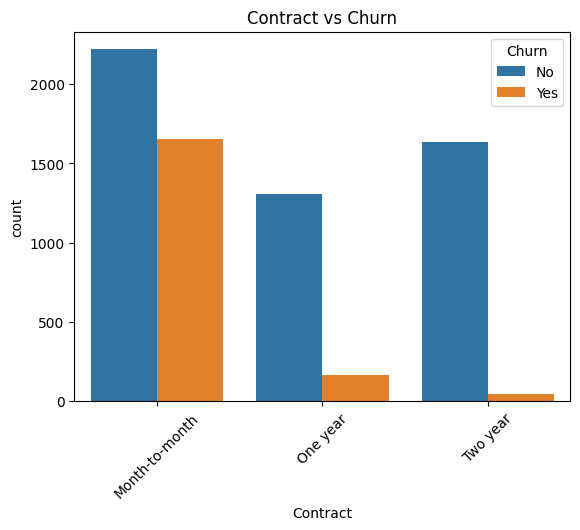

In [11]:
#contract vs churn
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Contract vs Churn")
plt.xticks(rotation=45)
plt.show()


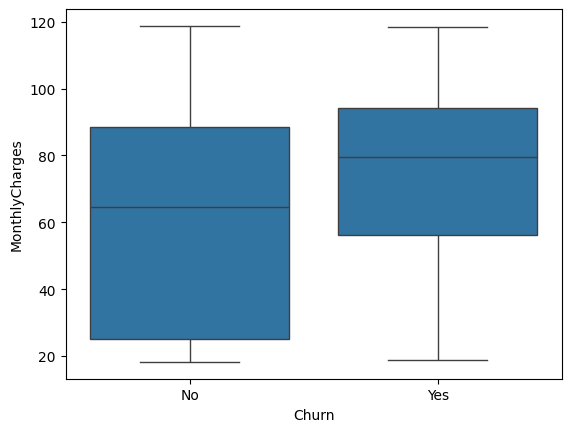

In [12]:
#monthlycharges vs churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.show()

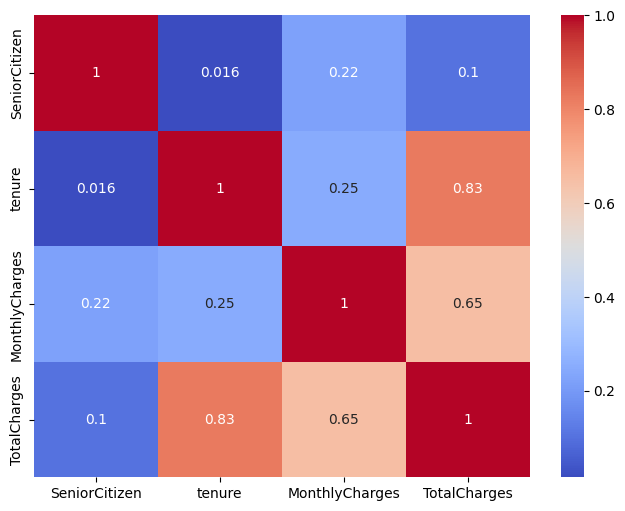

In [13]:
#correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [14]:
# Clean target column properly
df['Churn'] = df['Churn'].astype(str).str.strip().str.lower()

# Map to binary
df['Churn'] = df['Churn'].map({'yes':1, 'no':0})

# Drop rows where mapping failed
df = df[df['Churn'].notna()]

# Convert to integer
df['Churn'] = df['Churn'].astype(int)
print(df['Churn'].value_counts())


Churn
0    5163
1    1869
Name: count, dtype: int64


In [27]:
# Separate features and target
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(X_train.shape)
print(y_train.shape)


(5625, 30)
(5625,)


In [16]:
X = pd.get_dummies(X, drop_first=True)


In [17]:
#handle class imbalance (SMOTE)
sm=SMOTE(random_state=42)
X_train_res, y_train_res =sm.fit_resample(X_train, y_train)
print(y_train_res.value_counts())

Churn
0    4130
1    4130
Name: count, dtype: int64


In [18]:
print(X_train_res.shape)
print(X_test.shape)

(8260, 30)
(1407, 30)


In [19]:
#feature scaling
scaler=StandardScaler()
X_train_res=scaler.fit_transform(X_train_res)
X_test=scaler.transform(X_test)

In [20]:
#Model 1 :Logistic Regression
log_model=LogisticRegression(max_iter=1000)
log_model.fit(X_train_res, y_train_res)
y_pred_log=log_model.predict(X_test)
y_prob_log=log_model.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_pred_log))
print("ROC-AUC Score:", roc_auc_score(y_test,y_prob_log))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1033
           1       0.55      0.65      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.77      1407

ROC-AUC Score: 0.8168035057022017


In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))



              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1033
           1       0.58      0.59      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407

ROC-AUC Score: 0.8150019930527873


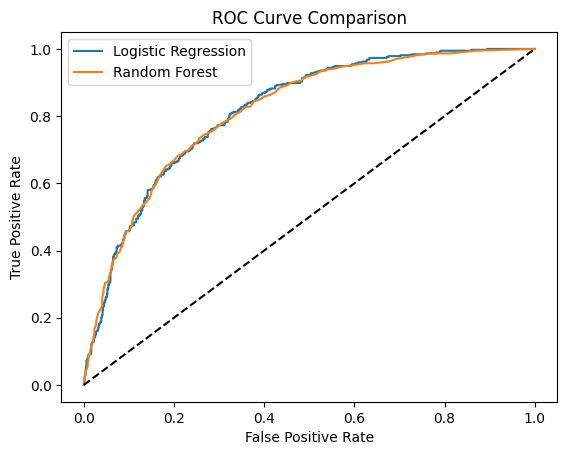

In [22]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [23]:
feature_importances = pd.Series( rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances.head(10))


TotalCharges                      0.166578
tenure                            0.154899
MonthlyCharges                    0.133495
PaymentMethod_Electronic check    0.103197
InternetService_Fiber optic       0.054159
PaperlessBilling_Yes              0.038539
Contract_Two year                 0.036847
gender_Male                       0.023628
MultipleLines_Yes                 0.023527
Contract_One year                 0.022121
dtype: float64


In [30]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)


Best Parameters: {'model__C': 1}
Best CV ROC-AUC: 0.8323681845052515


In [32]:
best_model = grid.best_estimator_

y_prob = best_model.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


Test ROC-AUC: 0.8168035057022017
